Abgabe 2 Mark Nagengast Porro, Tim Schwabe

Aufgabe 1

In [201]:
import networkx as nx
import numpy as np
import matplotlib as plt
import operator


In [202]:
alpha = 1
pop_size = 100

In [203]:
def createGraph(n_nodes, n_edges):
    G = nx.Graph()
    G.add_nodes_from([i for i in range(0,n_nodes)])

    for n in range(n_edges):
        a = np.random.randint(n_nodes)
        while True:
            b = np.random.randint(n_nodes)
            if a != b:
                break
        G.add_edge(a,b)
    
    return G


G = createGraph(10,20)


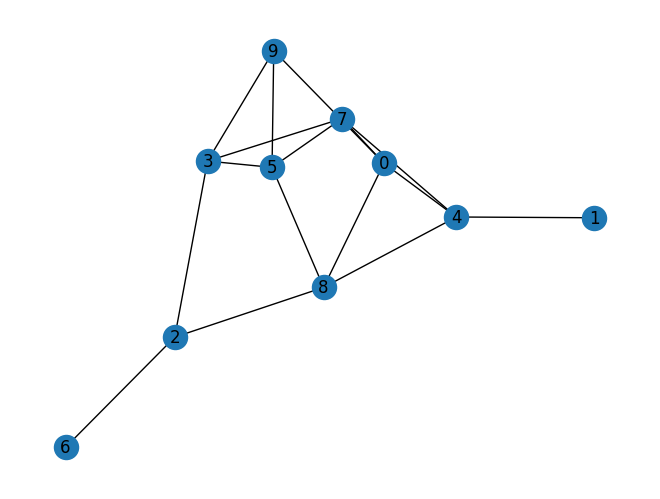

In [204]:
nx.draw(G, with_labels = True)

Aufgabe 2

In [205]:
def init_population(G):
    dic = dict()
    for i in G.nodes():
        
        dic.update([((i,),0)])
    return dic

In [206]:
def fitness(population, G):
    fitness = 0

    for key in population:
        fitness = 0
        for i in range(len(key)-1):
            for j in range(i+1,len(key)):
                if G.has_edge(key[i], key[j]):
                    fitness += 1
                else: 
                    fitness -= alpha*len(key)
        population.update([(key, fitness)])


Aufgabe 3

In [207]:
# Selektion
def selection(population):
    return dict(sorted(population.items(),key=operator.itemgetter(1),reverse=True)[:10])


In [208]:
# Rekombination
def recombination(pop):
    new_pop = dict()
    for i in range(len(pop)-1):
        for j in range(i+1,len(pop)):
            appended = list(set(list(pop)[i] + list(pop)[j]))
            while len(appended) > max(len(list(pop)[i]), len(list(pop)[j])) + 1:
                random_idx = np.random.choice(len(appended))
                del appended[random_idx]
            appended = tuple(appended)
            new_pop.update([(appended,0)])
    return new_pop

In [209]:
#Mutation:
def mutation(dic,G):
    newDic = dict()
    for key in dic:
        newKey = list(key)
        #removing nodes
        for node in newKey:
            if np.random.rand(1) < 0.05:
                newKey.remove(node)
        #adding nodes
        for node in G.nodes():
            if np.random.rand(1) < 0.02:
                newKey.append(node)
        newDic.update([(tuple(set(newKey)),0)])
    
    return newDic

In [210]:
counter = 0
for i in range(1000):
    n_nodes = np.random.randint(100)
    n_edges = np.random.randint(1000)
    G = createGraph(10,20)
    population = init_population(G)
    repeat_c = 0
    best_value = -100
    while True:
        fitness(population,G)
        population = selection(population)
        tmp = population.get(list(population)[0])
        if(tmp == best_value):
            repeat_c += 1
        else:
            best_value = tmp

        if repeat_c > 10:
            break


        childs = mutation(recombination(population),G)
        population = population | childs

    print(population)

    if not len(list(population)[0]) == max(len(c) for c in nx.find_cliques(G)):
        counter += 1

print((1000-counter)/1000)   

0.987
